In [11]:
import gym
import gym_chess
import chess
from gym_chess.alphazero import MoveEncoding
import numpy as np
import random
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf

In [12]:
env = gym.make("Chess-v0")
env = MoveEncoding(env)
INPUT_DIM = 8*8
OUTPUT_DIM = 8*8*73

In [13]:
class DQNAgent:
    def __init__(self,num_episodes,avg_num_episodes,learning_rate = 0.1,discount_rate = 0.99):
        self.min_exploration_rate = 0.01
        self.max_exploration_rate = 1
        self.exploration_decay_rate = 0.001
        self.num_episodes = num_episodes
        self.avg_num_episodes = avg_num_episodes
        self.reward = 1
        self.gamma = 0.95
        self.exploration_rate = 1
        self.rewards_all_episodes = []
        self.results = []
        self.times_all_episodes = []
        self.time_results = []
        self.model = self.build_model()
        self.opt = tf.optimizers.Adam(0.001)
        
    def calculateAvgReward(self):
        rewards_per_thousand_episodes = np.split(np.array(self.rewards_all_episodes),self.num_episodes/self.avg_num_episodes)
        count = self.avg_num_episodes
        for r in rewards_per_thousand_episodes:
#             avg_per_thousand_episode = str(sum(r/self.avg_num_episodes))
            sum_of_rewards = int(sum(r))
            self.results.append({"episode":count,"reward":sum_of_rewards})
            count += self.avg_num_episodes
            
    def calculateAvgTime(self):
        times_per_thousand_episodes = np.split(np.array(self.times_all_episodes),self.num_episodes/self.avg_num_episodes)
        count = self.avg_num_episodes
        for r in times_per_thousand_episodes:
            avg_per_thousand_episode = sum(r/self.avg_num_episodes)
            avg_sec_per_thousand_episode = avg_per_thousand_episode % 60
            self.time_results.append({"episode":count,"seconds":avg_sec_per_thousand_episode})
            count += self.avg_num_episodes
            
    def createLinePlotForRewards(self):
        df = pd.DataFrame(self.results)
        fig, ax1 = plt.subplots(figsize=(12, 8))
        sns.lineplot(data=df, x="episode", y="reward", ax=ax1, ci=None)
        ax1.set_ylabel('Rewards',fontsize=13)
        ax1.set_xlabel('Episodes',fontsize=13)
        ax1.set_title("Average reward per "+str(self.avg_num_episodes)+" episodes",fontsize=16)
        
    def createLinePlotForDuration(self):
        df = pd.DataFrame(self.time_results)
        fig, ax1 = plt.subplots(figsize=(12, 8))
        sns.lineplot(data=df, x="episode", y="seconds", ax=ax1, ci=None)
        ax1.set_ylabel('Seconds',fontsize=13)
        ax1.set_xlabel('Episodes',fontsize=13)
        ax1.set_title("Average time per "+str(self.avg_num_episodes)+" episodes",fontsize=16)
        
        
    def build_model(self):
        inputs = tf.keras.layers.Input(INPUT_DIM)
        net = tf.keras.layers.Dense(64,activation='tanh')(inputs)
        net = tf.keras.layers.Dense(64,activation='tanh')(net)
        outputs = tf.keras.layers.Dense(OUTPUT_DIM)(net)
        model = tf.keras.Model(inputs,outputs)
        return model
    
    def getCurrentState(self,state):
        bstate = np.zeros(64)
        for i in range(64):
            p = state.piece_at(i)
            if p is not None:
                bstate[i] = {"P": 1, "N": 2, "B": 3, "R": 4, "Q": 5, "K": 6, \
                     "p": 9, "n":10, "b":11, "r":12, "q":13, "k": 14}[p.symbol()]
        return np.array([bstate])
    
    def loss_grads(self,state, target):
        with tf.GradientTape(persistent=True) as tape:
            pred = self.model(state)
            loss = tf.reduce_mean(tf.square(pred-target))
        grads = tape.gradient(loss,self.model.trainable_variables)
        return loss, grads
    
    def actRandom(self,legal_moves):
        return env.encode(random.choice(list(legal_moves)))
    
    def act(self,state,legal_moves):
        self.exploration_rate_threshold = random.uniform(0, 1)
        if self.exploration_rate_threshold >= self.exploration_rate:
            action = env.encode(random.choice(list(legal_moves))) # Exploration
        else:
            act_values = self.model.predict(state)
            contains_nan = np.isnan(act_values[0]).any()
            if contains_nan:
                print('NN broken or None')
                return -1
            actions = []
            for move in list(legal_moves):
                actions.append(env.encode(move))
            for idx in range(len(act_values[0])):
                if idx not in actions:
                    act_values[0][idx] = -np.inf
            action = np.argmax(act_values[0]) # Exploitation
#         print('action: ', action, 'val', act_values[0][action])
        return action  # returns action
    
    def play(self,ic_n):
        intermittent_count = 0
        for episode in range(num_episodes):
            
            finished = False
            rewards_current_episode = 0
            start_time = time.time()
            state = env.reset()
            
            clear_output(wait=True)
            print("*****EPISODE ", episode+1, "*****\n\n\n\n")

            while not finished:
                if state.is_checkmate() or state.is_stalemate() or state.is_insufficient_material() or \
                    state.is_game_over() or state.can_claim_threefold_repetition() or state.can_claim_fifty_moves() or \
                    state.can_claim_draw() or state.is_fivefold_repetition() or state.is_seventyfive_moves():
                    finished = True

                if finished:
                    break
                else:
                    if state.turn: ## White move
                        nn_state = self.getCurrentState(state)
                        current_action = self.act(nn_state,state.legal_moves)
                    else:
                        current_action = self.actRandom(state.legal_moves)
                    
                    new_state, reward, done, info = env.step(current_action)
                    
                    if new_state.turn: ## White move
                        curr_state = self.getCurrentState(new_state)

                        #  print('curr_state: ', curr_state)
                        if intermittent_count == 0:
                            prev_state = nn_state
                            prev_pred = self.model(prev_state)
                            prev_action = tf.argmax(prev_pred)
                            intermittent_count = ic_n
                        else:
                            intermittent_count -= 1


                        curr_pred = self.model(curr_state)

                        curr_value = tf.reduce_sum(curr_pred)

                        target = prev_pred.numpy()
                        target[prev_action] = reward + self.gamma * curr_value

                        self.exploration_rate *= 0.001

                        loss,grads = self.loss_grads(prev_state, target)
                        self.opt.apply_gradients(zip(grads,self.model.trainable_variables))

                    state = new_state
                    rewards_current_episode += reward
                    
            end_time = time.time()
            time_lapsed = end_time - start_time
            self.times_all_episodes.append(time_lapsed)
            self.rewards_all_episodes.append(rewards_current_episode)
            
            # Exploration rate decay
            self.exploration_rate = self.min_exploration_rate + \
                (self.max_exploration_rate - self.min_exploration_rate) * np.exp(-self.exploration_decay_rate*episode)
            
        self.calculateAvgReward()
        self.createLinePlotForRewards()
        
#         self.calculateAvgTime()
#         self.createLinePlotForDuration()

In [14]:
num_episodes = 1000
avg_num_episodes = round(num_episodes/10)
agent = DQNAgent(num_episodes,avg_num_episodes)

*****EPISODE  1000 *****






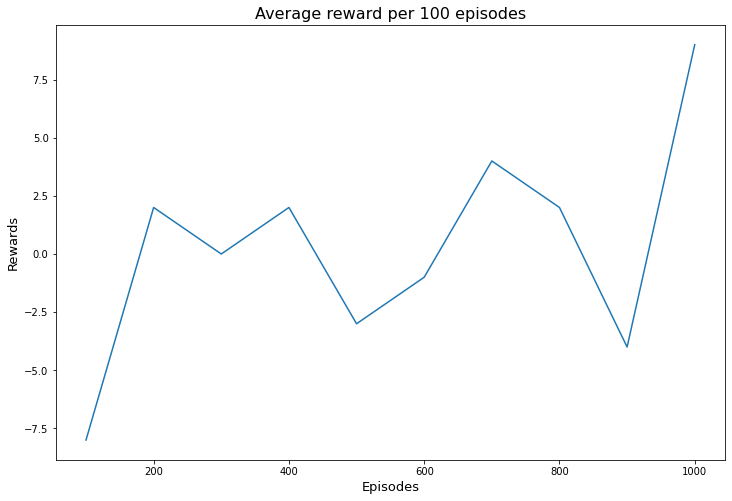

In [15]:
ic_n = 0
agent.play(ic_n)